# Урок 8. Проверяем работу модели на практике: A/B-тестирование

In [25]:
# подключаем библиотеки

import functions as func
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
def hyperopt_xgb_score(params):
    clf = xgb.XGBClassifier(**params)
    current_score = cross_val_score(clf, x_test, y_test, cv = 3).mean()
    return -current_score

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null object
RecordEnd            59455 non-null object
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-null float64
dtypes

In [4]:
# Предобработайте данные

NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()


Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [5]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

df['Gender'], GenderRef = func.SeriesFactorizer(df['Gender'])
df['MariStat'], MariStatRef = func.SeriesFactorizer(df['MariStat'])

df['SocioCateg'] = df['SocioCateg'].str.slice(0,4)

df = pd.get_dummies(df, columns = ['VehUsage','SocioCateg'])

df = df.select_dtypes(exclude = ['object'])

df['DrivAgeSq'] = df['DrivAge'].apply(lambda x: x**2)

df['ClaimsCount'] = df['ClaimInd'] + df['ClaimNbResp'] + \
                df['ClaimNbNonResp'] + df['ClaimNbParking'] + df['ClaimNbFireTheft'] + df['ClaimNbWindscreen']
df.loc[df['ClaimAmount'] == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis = 1, inplace = True)

{0: 'Male', 1: 'Female'}
{0: 'Other', 1: 'Alone'}


In [6]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis = 1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [7]:
dfAC = df[df['ClaimsCount'] > 0].copy()
dfAC['AvgClaim'] = dfAC['ClaimAmount']/dfAC['ClaimsCount']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
Exposure                           115155 non-null float64
LicAge                             115155 non-null int64
Gender                             115155 non-null int64
MariStat                           115155 non-null int64
DrivAge                            115155 non-null int64
HasKmLimit                         115155 non-null int64
BonusMalus                         115155 non-null int64
ClaimAmount                        115155 non-null float64
ClaimInd                           115155 non-null int64
OutUseNb                           115155 non-null float64
RiskArea                           115155 non-null float64
VehUsage_Private                   115155 non-null uint8
VehUsage_Private+trip to office    115155 non-null uint8
VehUsage_Professional              115155 non-null uint8
VehUsage_Professional run          115155 non-null uint8
SocioCateg_CSP1           

In [9]:
print(f"До: {df['ClaimsCount'].unique()}")
df.loc[df.ClaimsCount == 11, 'ClaimsCount'] = 10
print(f"После: {df['ClaimsCount'].unique()}")

До: [ 0.  4.  2.  1.  3.  5.  6.  7.  8.  9. 11.]
После: [ 0.  4.  2.  1.  3.  5.  6.  7.  8.  9. 10.]


In [10]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount')['ClaimAmount'].count().reset_index()
                         .rename(columns={'ClaimAmount': 'Count'}), 
             columns=['Count'])
FreqCount['Freq'] = FreqCount.index/FreqCount.Count

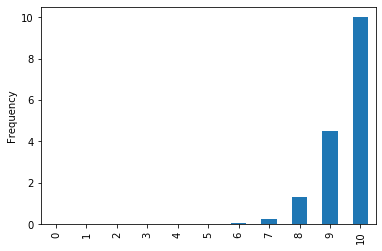

In [11]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [12]:
FreqCount.head(10)

,Count,Freq
0,104286,0.000000
1,3339,0.000299
2,3529,0.000567
3,2310,0.001299
4,1101,0.003633
5,428,0.011682
6,127,0.047244
7,26,0.269231
8,6,1.333333
9,2,4.500000


*Судя по данным, присуисивуеи проблема несбалансированности классов, т.ч. надо бы избавиться от неё. Для этого воспользуемся взвешиванием наблюдений для обучения модели, создав столбец `weight` и присвоем ему некоторые значения, например, можно задать 0.05 для значений ClaimsCount 0, а для остальных - 1. Но это не самый лучший метод.*

In [13]:
df['weight'] = 1
df.loc[df['ClaimsCount']==0, ['weight']] = 0.05

*Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.*

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis = 1), 
                                                        df['ClaimsCount'], test_size = 0.3, random_state = 10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [15]:
xgb_train = xgb.DMatrix(data=x_train.drop(['weight'], axis = 1), label = y_train, weight = x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop(['weight'], axis = 1), label = y_valid)
xgb_test = xgb.DMatrix(data=x_test.drop(['weight'], axis = 1), label = y_test)

In [16]:
# попробуем такие гиперпарамметры

space_xgb = {'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
             'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
             'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'num_class': df['ClaimsCount'].unique().size,
             'eval_metric': 'auc',
             'objective': 'multi:softprob',
             'nthread': 4,
             'booster': 'gbtree',
             'tree_method': 'exact',
             'verbosity': 0
            }


In [27]:
best = fmin(fn = hyperopt_xgb_score, space = space_xgb, algo = tpe.suggest, max_evals = 10)

D:\progs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
D:\progs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
D:\progs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
D:\progs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members 

In [29]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_xgb, best)
best_params

{'booster': 'gbtree',
 'colsample_bytree': 0.9500000000000001,
 'eta': 0.05,
 'eval_metric': 'auc',
 'gamma': 0.5,
 'max_depth': 6,
 'min_child_weight': 2.0,
 'n_estimators': 200,
 'nthread': 4,
 'num_class': 11,
 'objective': 'multi:softprob',
 'subsample': 0.7000000000000001,
 'tree_method': 'exact',
 'verbosity': 0}

In [31]:
# теперь можно применить к нашей модели заготовленные параметры

xgb_multiclass = xgb.train(params=best_params,
                           dtrain=xgb_train,
                           num_boost_round=30,
                           feval=hyperopt_xgb_score,
                           maximize=True,
                           early_stopping_rounds=None,
                           evals_result=None,
                           verbose_eval=False)


In [32]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    # Посчитаем предсказанные значения
    class_preds = [range(0, space_xgb['num_class'])[idx] for idx in np.argmax(xgb_multiclass.predict(dfset['dmat']), axis=1)]
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.6985534934497817
F1 Score on valid: 0.6895154287037573
F1 Score on test: 0.6912701169387518


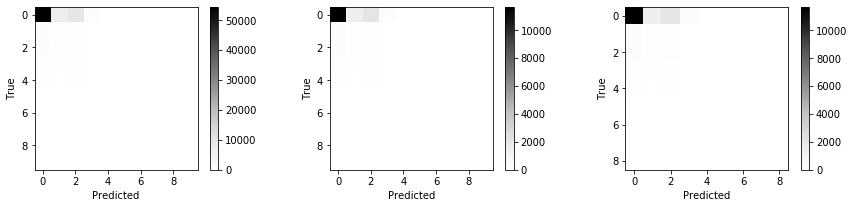

In [33]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'].values,
            [range(0, space_xgb['num_class'])[idx] for idx in np.argmax(xgb_multiclass.predict(dfsets[i]['dmat']), axis=1)])
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

## Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Судить о качестве модели тяжело, т.к. модель, похоже, получилась посредственной из-за чего видно дисбаланс классов, т.к. у нас подавляющее большинство объектов класса 0, мало объектов класса 1-3 и очень мало объектов класса 4-10. Как вариант, можно использовать бинарную классификацию, а убыточные полисы уже предсказывать на количество случаев по полису другой моделью.